### Detail description is in Problem1_a_the_other_two_methods.pdf (but is Chinese)

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import quad

def simulate_squid_game_v2(L, N, p, T):
    """
    Simulate the Squid Game scenario for T turns.
    
    Parameters:
    - L (int): Max number of players that can be sent back to the start line
    - N (int): Total number of players
    - p (list): List of N probabilities of failing to freeze for each player
    - T (int): Number of turns to simulate
    
    Returns:
    dict: A dictionary where the keys are player indices and the values are dictionaries.
          The inner dictionaries have keys as positions and values as the probability of 
          each player being in that position after T turns.
    """
    # Initialize players' positions
    positions = np.zeros(N, dtype=int)
    
    # Store the history of each player's position
    history = np.zeros((N, T+1), dtype=int)
    
    # Simulate the game for T turns
    for t in range(T):
        # Move all players one step forward
        positions += 1
        
        # Determine which players failed to freeze
        failed_to_freeze = np.random.rand(N) < p
        
        # If more than L players failed to freeze, find the L players who traveled the farthest
        if np.sum(failed_to_freeze) > L:
            # Find the indices of the L players who traveled the farthest and failed to freeze
            farthest_failed_indices = np.argsort(positions * failed_to_freeze)[-L:]
            
            # Send them back to the starting line
            positions[farthest_failed_indices] = 0
        else:
            # Send all players who failed to freeze back to the starting line
            positions[failed_to_freeze] = 0
        
        # Update history
        history[:, t+1] = positions
        
    # Calculate the probability distributions for each player
    prob_distributions = {}
    for i in range(N):
        # Count occurrences of each position and divide by T to get probabilities
        unique, counts = np.unique(history[i, :], return_counts=True)
        prob_distributions[i] = dict(zip(unique, counts))
    
    return prob_distributions

def estimate_inverse_cdf(x, mu, sigma):
    """
    Calculate the cumulative distribution function (CDF) of a normal distribution
    at point 2*mu - x, where the mean of the distribution is mu and the standard
    deviation is sigma.
    
    Parameters:
    - x (float): The point from which to evaluate the CDF.
    - mu (float): The mean of the distribution.
    - sigma (float): The standard deviation of the distribution.
    
    Returns:
    float: The value of the CDF at 2*mu - x.
    """
    return norm.cdf(2*mu - x, loc=mu, scale=sigma)
def estimate_sum(mu, sigma):
    sum_total=0
    for i in range(0,int(mu+4*sigma)):
        sum_total+=estimate_inverse_cdf(i, mu, sigma)
    return sum_total

def plot_simulation_vs_estimate(p, result, probabilities_estimated, people_order=0,T=1000000):
    """
    Plot the simulated and estimated probabilities along with their relative error.
    
    Parameters:
    - result (dict): Output from the simulate_squid_game_v2 function
    - p (list): List of N probabilities of failing to freeze for each player
    
    Returns:
    None
    """
    # Extract position probabilities for player 0 from simulation
    #probabilities_estimated*=T
    positions_simulated = list(result[people_order].keys())
    probabilities_simulated = list(result[people_order].values())
    probabilities_simulated=[i/T for i in probabilities_simulated]
    

    # Estimate probabilities for the same positions
    #probabilities_estimated = [estimate(p[people_order], k) for k in positions_simulated]

    # Calculate relative errors
    rel_errors = [abs(est - sim) / sim for est, sim in zip(probabilities_estimated, probabilities_simulated)]

    # Create plots
    plt.figure(figsize=(15, 5))

    # Plot probabilities
    plt.subplot(1, 2, 1)
    plt.plot(positions_simulated, probabilities_simulated, label='Simulated')
    plt.plot(positions_simulated, probabilities_estimated, label='Estimated', linestyle='--')
    plt.xlabel(f"Position (k), Np={p[people_order]*len(p)}")
    plt.ylabel('Probability')
    plt.title('Probabilities: Simulated vs. Estimated')
    plt.legend()

    # Plot relative errors
    plt.subplot(1, 2, 2)
    plt.plot(positions_simulated, rel_errors, label='Rel. Error', color='red')
    plt.xlabel(f"Position (k), Np={p[people_order]*len(p)}")
    plt.ylabel('Relative Error')
    plt.title('Relative Error: Simulated vs. Estimated')
    plt.legend()

    # Display plots
    plt.tight_layout()
    plt.show()
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad


def pdf_normal(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def cdf_normal(x, mu, sigma):
    return (1/2) * (1 + np.math.erf((x - mu) / (sigma * np.sqrt(2))))

def invert_cdf(x, mu, sigma):
    return (1 - cdf_normal(x, mu, sigma))

def distribution_invert_cdf(x, mu, sigma):
    integral_invert_cdf, _ = quad(lambda t: invert_cdf(t, mu, sigma), 0, 2*mu)
    return invert_cdf(x, mu, sigma) / integral_invert_cdf


def condition_for_x(x, mu, sigma, p):
    # Numerical integration from x to infinity of H(t)
    integral_distribution_invert_cdf, _ = quad(lambda t: distribution_invert_cdf(t, mu, sigma), x, np.inf)
    return integral_distribution_invert_cdf - p

def find_x(mu, sigma, p):
    x_initial_guess = mu
    x_solution = fsolve(condition_for_x, x_initial_guess, args=(mu, sigma, p))
    return x_solution[0]
# mu=49
# want_p=0.5
# closest_sigma=1
# diff=100
# for i in range(1,50):
#     a=find_x(mu, i, 1/50)
#     b=invert_cdf(a+1, mu, i)/invert_cdf(a, mu, i)
#     if abs(b-(1-want_p))<diff:
#         diff=abs(b-(1-want_p))
#         closest_sigma=i

# print(closest_sigma)

def ap_by_2(mu, want_p, r, times=30):
    #r=r*(1-want_p)
    pre_max=mu
    pre_min=0
    sigma=mu/2
    diff=100
    best_sigma=0
    for time in range(times):
        evaluate_x=find_x(mu, sigma, r)
        evaluate=invert_cdf(evaluate_x+1, mu, sigma)/invert_cdf(evaluate_x, mu, sigma)
        #print(evaluate)
        #print(sigma,abs(evaluate-(1-want_p)))
        if abs(evaluate-(1-want_p))<diff:
            diff=abs(evaluate-(1-want_p))
            best_sigma=sigma
        if evaluate>1-want_p:
            pre_max=sigma
            sigma=(sigma+pre_min)/2
        else:
            pre_min=sigma
            sigma=(sigma+pre_max)/2
    return best_sigma

def custom_integral(mu, sigma, l, num):
    """
    Compute the integral of PDF(x) * (num+x-l)dx from (l-num) to l
    where PDF(x) is the PDF of a normal distribution with mean mu and standard deviation sigma
    
    Parameters:
    mu (float): mean of the normal distribution
    sigma (float): standard deviation of the normal distribution
    l (float): upper limit of the integral
    num (float): range of the integral
    
    Returns:
    float: result of the integral
    """
    # 定义被积函数
    def integrand(x, mu, sigma, l, num):
        pdf = norm.pdf(x, mu, sigma)  # 计算正态分布的概率密度函数
        return pdf * (l-x)
    
    # 计算积分
    result, _ = quad(integrand, l-num, l, args=(mu, sigma, l, num))
    result += norm.cdf(l, mu, sigma) * (num)
    #print(norm.cdf(l-num, mu, sigma))
    return result

def custom_integral_true_L(mu, sigma, l):
    """
    Compute the integral of PDF(x) * (num+x-l)dx from (l-num) to l
    where PDF(x) is the PDF of a normal distribution with mean mu and standard deviation sigma
    
    Parameters:
    mu (float): mean of the normal distribution
    sigma (float): standard deviation of the normal distribution
    l (float): upper limit of the integral
    num (float): range of the integral
    
    Returns:
    float: result of the integral
    """
    # 定义被积函数
    def integrand1(x, mu, sigma, l):
        pdf = norm.pdf(x, mu, sigma)  # 计算正态分布的概率密度函数
        return pdf * x
    
    def integrand2(x, mu, sigma, l):
        pdf = norm.pdf(x, mu, sigma)  # 计算正态分布的概率密度函数
        return pdf
    
    # 计算积分
    result1, _ = quad(integrand1, -np.inf, l, args=(mu, sigma, l))
    result2, _ = quad(integrand2, l, np.inf, args=(mu, sigma, l))
    print(result1, result2*l)
    return result1+result2*l

def find_init_people(L,N,p):
    mu=N*p
    sigma=np.sqrt(N*p*(1-p))
    return custom_integral_true_L(mu, sigma, L)

def estimate_equal_p(L,N,p,T=1000000):
    p_list=[p]*N
    result= simulate_squid_game_v2(L, N, p_list, T)
    positions_simulated = list(result[0].keys())
    cur_num=find_init_people(L,N,p)
    predict_num=N
    probabilities_estimated=np.array([cur_num])
    total_sum=0
    while len(probabilities_estimated)<len(positions_simulated):
        total_sum+=cur_num
        predict_num-=cur_num
        mu=predict_num*p
        sigma=(predict_num*p*(1-p))**0.5
        integral=custom_integral(mu, sigma, L, cur_num*p)
        cur_num=cur_num-integral
        probabilities_estimated=np.append(probabilities_estimated, cur_num)

    probabilities_estimated/=N
    plot_simulation_vs_estimate(p_list, result, probabilities_estimated, people_order=0)
    
    
#estimate_equal_p(5,100,0.2)
def method_2(N,L,p0,T=100000):
    p=[p0]*N
    mu=N/L-1
    people_order=0

    sigma=ap_by_2(mu, p0, 1/N, times=40)
    print(sigma)
    sum0=estimate_sum(mu, sigma)

    def estimate_equal_large(x):
        return estimate_inverse_cdf(x, mu, sigma)
    def estimate_equal_small(k):
        return p0*(1-p0)**(k)    
    p_small=norm.cdf(L, loc=N*p0, scale=N*p0*(1-p0)/5)
    #p_small=1
    p_large=1-p_small
    print(p_small, p_large)
        

    result= simulate_squid_game_v2(L, N, p, T)
    positions_simulated = list(result[people_order].keys())
    probabilities_estimated_large=estimate_equal_large(np.array(positions_simulated))
    probabilities_estimated_small=estimate_equal_small(np.array(positions_simulated))
    probabilities_estimated=p_large*probabilities_estimated_large+p_small*probabilities_estimated_small
    probabilities_estimated/=np.sum(probabilities_estimated)
    plot_simulation_vs_estimate(p, result, probabilities_estimated, people_order,T=T)



def method_3(N,L,p0,T=100000):
    p=[p0]*N
    people_order=0

    result= simulate_squid_game_v2(L, N, p, T)
    positions_simulated = list(result[people_order].keys())


    def estiminate(x, judge, p):
        middle = p * (1 - p)**judge
        double_middle = 2 * middle
        
        # 使用NumPy的向量化操作来处理数组x
        result = np.where(x < judge, double_middle - p * (1 - p)**(2*judge - x), p * (1 - p)**x)
        
        return result/sum(result)
        
    estiminate_num=estiminate(np.array(positions_simulated),N/L-1,p0)
    #print(estiminate_num)
    plot_simulation_vs_estimate(p, result, estiminate_num, people_order=0,T=T)

### Verification

5.355380205856818
1.5307192759192892e-13 0.9999999999998469


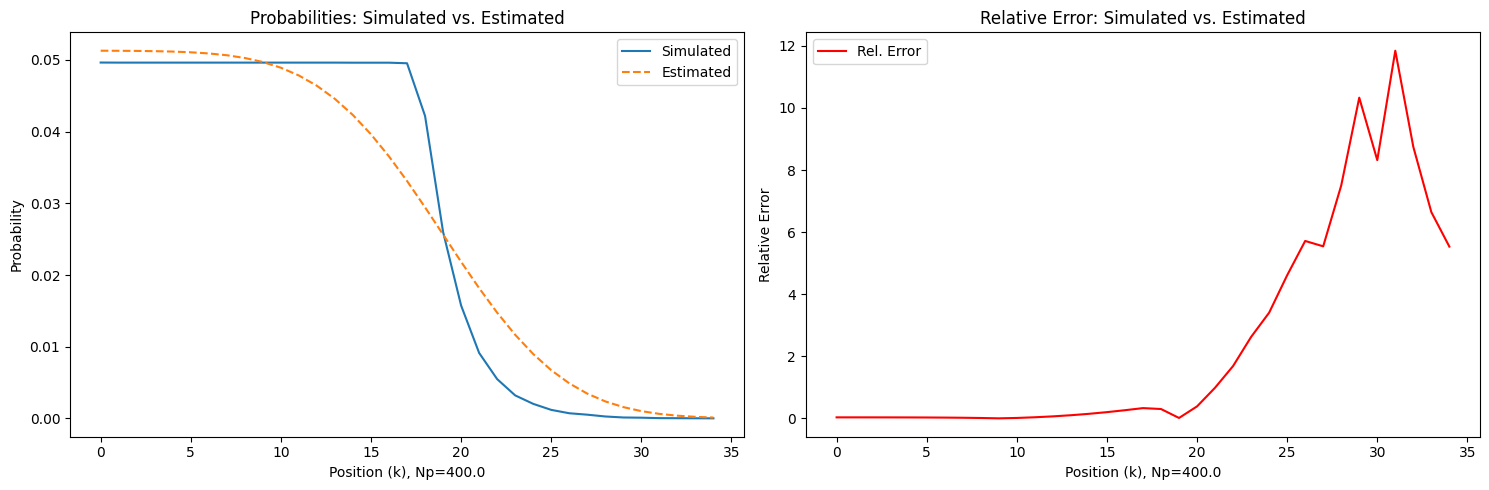

In [11]:

L = 50
N = 1000
p0=0.4
T = 100000
method_2(N,L,p0,T=100000)

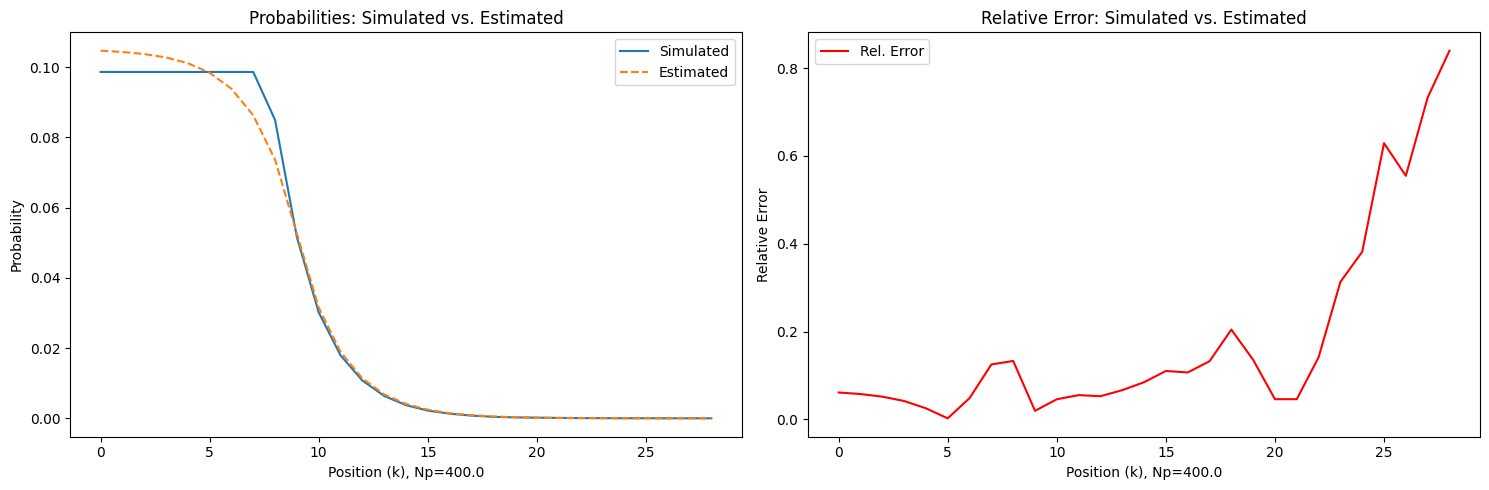

In [25]:
L = 100
N = 1000
p0=0.4
T = 100000
method_3(N,L,p0,T=100000)